<center>

# Football Analytics

Neste notebook iremos explorar dados gratuitos disponibilizados pelo StatsBomb.  

## IMPORTANDO AS BIBLIOTECAS NECESSÁRIAS

In [1]:
# Importando Bibliotecas necessárias
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from urllib.request import urlopen
from mplsoccer import Sbopen, Pitch, FontManager, VerticalPitch, add_image
from PIL import Image
from statsbombpy import sb

In [2]:
competitions = sb.competitions()

In [3]:
# Criando uma lista com todas competições e seus respectivos ids, ordenadas de forma alfabética
competitions_list = competitions[['competition_name', 'competition_id']].drop_duplicates().reset_index(drop=True)
competitions_list

,competition_name,competition_id
0,1. Bundesliga,9
1,African Cup of Nations,1267
2,Champions League,16
3,Copa America,223
4,Copa del Rey,87
5,FA Women's Super League,37
6,FIFA U20 World Cup,1470
7,FIFA World Cup,43
8,Indian Super league,1238
9,La Liga,11


In [4]:
# Criando uma lista com todas as temporadas listadas da mais recente para a mais antiga
seasons_list = competitions[['season_name', 'season_id']].sort_values(by='season_name', ascending=False).drop_duplicates().reset_index(drop=True)
seasons_list.set_index('season_name').head(10)

,season_id
season_name,
2024,282
2023/2024,281
2023,107
2022/2023,235
2022,106
2021/2022,108
2020/2021,90
2020,43
2019/2020,42


# SELECIONANDO COMPETIÇÃO E TEMPORADA

In [5]:
df_championship = sb.matches(competition_id=43 , season_id=106 )

In [6]:
df_championship['home_team'].sort_values().unique()

array(['Argentina', 'Australia', 'Belgium', 'Brazil', 'Cameroon',
       'Canada', 'Costa Rica', 'Croatia', 'Denmark', 'Ecuador', 'England',
       'France', 'Germany', 'Ghana', 'Iran', 'Japan', 'Mexico', 'Morocco',
       'Netherlands', 'Poland', 'Portugal', 'Qatar', 'Saudi Arabia',
       'Senegal', 'Serbia', 'South Korea', 'Spain', 'Switzerland',
       'Tunisia', 'United States', 'Uruguay', 'Wales'], dtype=object)

In [7]:
def data(team):
    
    df_team = df_championship.loc[(df_championship['home_team'] == f'{team}')|(df_championship['away_team'] == f'{team}')]
    match_list = df_team['match_id'].unique().tolist()
        
    # Inicializar o parser
    parser = Sbopen()

    # Listas para armazenar os dataframes
    all_df = []
    all_related = []
    all_freeze = []
    all_tactics = []

    # Iterar sobre cada ID de jogo e coletar os dados
    for id in match_list:
        df, related, freeze, tactics = parser.event(id)
            
        # Adicionar os dataframes coletados às listas correspondentes
        all_df.append(df)
        all_related.append(related)
        all_freeze.append(freeze)
        all_tactics.append(tactics)

    df_combined = pd.concat(all_df, ignore_index=True) # Informações de eventos detalhados
    related_combined = pd.concat(all_related, ignore_index=True) # Informação de eventos relacionados (ex: Pass - Ball Receipt)
    freeze_combined = pd.concat(all_freeze, ignore_index=True) # Informações de coordenada dos eventos
    tactics_combined = pd.concat(all_tactics, ignore_index=True) # informações dos jogadores(nº camisa, posição, nome e ID)
    
    return df_combined, related_combined, freeze_combined, tactics_combined, df_team

## SELECIONANDO EQUIPE

In [14]:
team = 'Spain'
df_combined, related_combined, freeze_combined, tactics_combined, df_team = data(team=team)

In [16]:
# Extraindo os nomes completos dos jogadores da equipe selecionada anteriormente
df_players = df_combined[df_combined['team_name'] == team]
players_names = df_players['player_name'].sort_values().unique().tolist()
players_names

['Alejandro Balde Martínez',
 'Anssumane Fati',
 'Aymeric Laporte',
 'Carlos Soler Barragán',
 'César Azpilicueta Tanco',
 'Daniel Carvajal Ramos',
 'Daniel Olmo Carvajal',
 'Ferrán Torres García',
 'Jordi Alba Ramos',
 'Jorge Resurrección Merodio',
 'Marco Asensio Willemsen',
 'Marcos Llorente Moreno',
 'Nicholas Williams Arthuer',
 'Pablo Martín Páez Gavira',
 'Pablo Sarabia García',
 'Pau Francisco Torres',
 'Pedro González López',
 'Rodrigo Hernández Cascante',
 'Sergio Busquets i Burgos',
 'Unai Simón Mendibil',
 'Álvaro Borja Morata Martín',
 nan]

In [17]:
# Extraindo a fração para facilitar a visualização do id do jogo para seleção
team_match_ids = df_team['match_id'].unique().tolist()
df_team[df_team['match_id'].isin(team_match_ids)][['match_id', 'home_team', 'away_team']]

,match_id,home_team,away_team
23,3869220,Morocco,Spain
29,3857263,Spain,Germany
44,3857291,Spain,Costa Rica
62,3857255,Japan,Spain


In [18]:
def fouls_won_analysis(player=None, match=None):
    
    df_fouls = df_combined[df_combined['type_name'] == 'Foul Won']
    df_fouls = df_fouls[df_fouls['team_name'] == team]

    # Filtra as faltas de acordo com o jogo (se fornecido)
    if match is not None:
        df_fouls_filtered_match = df_fouls[df_fouls.match_id == match]
    else:
        df_fouls_filtered_match = df_fouls[df_fouls.match_id.isin(team_match_ids)]  # Todos os jogos da equipe

    # Filtra as faltas de acordo com o jogador (se fornecido)
    if player is not None:
        df_fouls_filtered_player = df_fouls_filtered_match[df_fouls_filtered_match.player_name == player].reset_index(drop=True)
    else:
        df_fouls_filtered_player = df_fouls_filtered_match.reset_index(drop=True)  # Todos os jogadores

    # Plotar apenas se houver dados
    if df_fouls_filtered_player.empty:
        print("Nenhuma falta encontrada para os filtros aplicados.")
        return

    
    pitch = Pitch(pitch_color='#aabb97', line_color='white', stripe_color='#c2d59d', stripe=True)


    first_third_fouls = df_fouls_filtered_player[df_fouls_filtered_player['x'] <= 40]
    second_third_fouls = df_fouls_filtered_player[(df_fouls_filtered_player['x'] > 40) & (df_fouls_filtered_player['x'] <= 80)]
    third_third = df_fouls_filtered_player[df_fouls_filtered_player['x'] > 80 ]

    print('faltas sofridas no primeiro terço:', len(first_third_fouls))
    print('faltas sofridas no segundo terço:', len(second_third_fouls))
    print('faltas sofridas no terceiro terço:', len(third_third))
    

    # Definindo as cores com base no terço do campo
    cores = []
    for _, row in df_fouls_filtered_player.iterrows():
        if row['x'] <= 40:
            cores.append('#FF0000')  # Vermelho para o primeiro terço (defensivo)
        elif 40 < row['x'] <= 80:
            cores.append('#0000FF')  # Azul para o segundo terço (meio-campo)
        else:
            cores.append('#000000')  # Preto para o último terço (ofensivo)


    fig, ax = pitch.draw(figsize=(10, 6))
    scatter = pitch.scatter(df_fouls_filtered_player.x, df_fouls_filtered_player.y, ax=ax, edgecolor='black', color=cores)
    
        # Legenda de resultados do chute (outcome)
    legend_colors = [
        mpatches.Patch(color='#FF0000', label='faltas sofridas no primeiro terço'),
        mpatches.Patch(color='#0000FF', label='faltas sofridas no segundo terço'),
        mpatches.Patch(color='#000000', label='faltas sofridas no terceiro terço')]


    plt.legend(
        handles=legend_colors,
        loc='upper left',
        bbox_to_anchor=(1, 1),
        title="Legenda",
        title_fontsize=14,
        fontsize=10)
    
    
    # Título com base nas condições
    if match is not None:
        df_home_away = df_team[df_team['match_id'] == match]
        home = df_home_away['home_team'].iloc[0]
        away = df_home_away['away_team'].iloc[0]
        title_match_info = f"{home} Vs {away}"
    else:
        title_match_info = "Todos os jogos"

    if player is not None:
        title_player_info = f"{player}"
    else:
        title_player_info = f"{team}"

    plt.title(f'Faltas Sofridas: {title_player_info} - {title_match_info} - {df_championship["competition"].loc[0]} {df_championship["season"].loc[0]}')
    plt.show()


faltas sofridas no primeiro terço: 1
faltas sofridas no segundo terço: 0
faltas sofridas no terceiro terço: 0


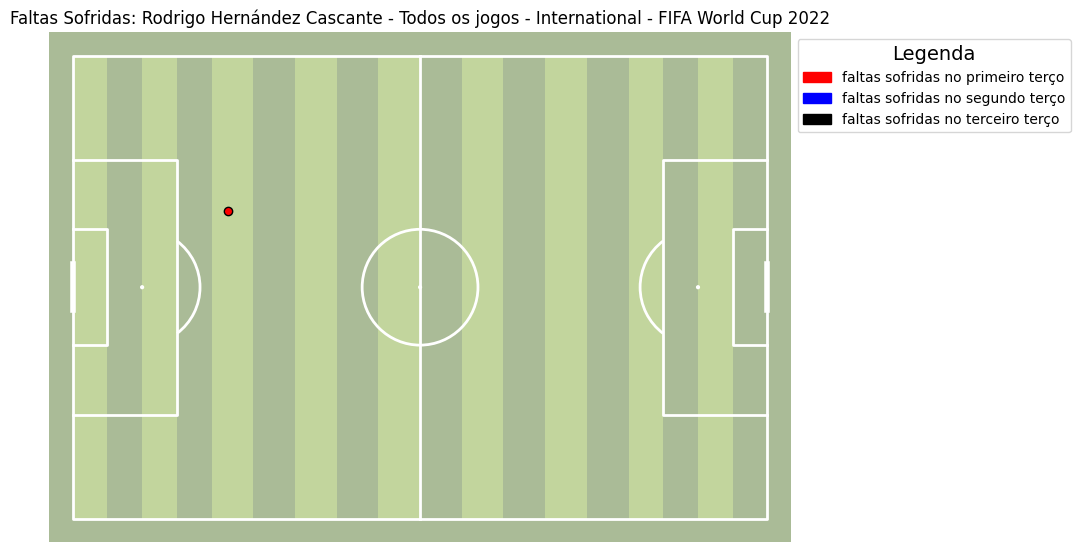

In [20]:
fouls_won_analysis(player='Rodrigo Hernández Cascante')